<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
This notebook shows marker images for the neurospheroids

</div>



In [ ]:
Also the organoid, neun 488 and map2 584
594

In [1]:
from skimage import io
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
from aicsimageio import AICSImage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import czifile
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
import pandas as pd
from datetime import datetime, timezone, timedelta
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry


def int_to_float(out):
    """
    Convert image data from integer to float format.

    Parameters:
    - out (np.ndarray): Input image data in integer format.

    Returns:
    - np.ndarray: Converted image data in float format.
    
    Note:
    If the input data type is 'uint16', the conversion is normalized to the range [0, 1]
    by dividing by ((2**16) - 1). If the input data type is 'uint8', the normalization
    is performed by dividing by ((2**8) - 1), resulting in the range [0, 1].
    """
    if out.dtype=='uint16':
        return out.astype(float)/((2**16)-1)
    elif out.dtype=='uint8':
        return out.astype(float)/((2**8)-1)

def load_image(path):
    img = AICSImage(path)
    #reshaped_img = img.data.reshape(30, 1024, 1024)
    return int_to_float(img.data[0])

In [2]:
import os
import matplotlib.patches as patches

folder_path = '../../imaging_data/022125-organoid-10x zoom/'
file_names = [f for f in os.listdir(folder_path) if f.endswith(('.czi'))]  # Adjust extensions as needed
images = [load_image(os.path.join(folder_path, file_name)) for file_name in file_names]

In [4]:
img = AICSImage(folder_path + file_names[0])
img.channel_names

# MAP2, NeuN, DAPI

['AF594-T2', 'AF488-T3', 'DAPI-T4']

In [5]:
dictionary = {'G2': 'p.Glu50fs*3', 'Y': 'p.Tyr622*', 'E3': 'WT'}

In [6]:
names = [dictionary[x.split('-')[0]] for x in file_names]

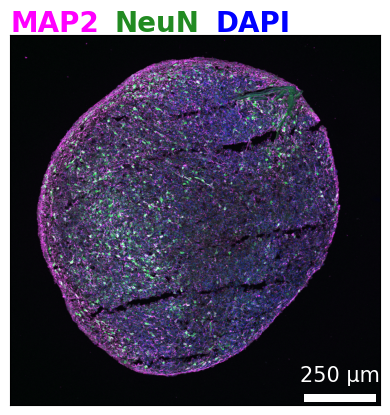

In [7]:
import numpy as np
import matplotlib.pyplot as plt
i = 5
# Assume images[i] has shape (channels, height, width)
# For example, (3, 1024, 1024)
temp = np.max(images[i], axis=1)  # Now temp.shape is (3, H, W)
img_channels_last = temp.transpose(1, 2, 0)  # Now shape is (H, W, 3)

# Create an empty RGB composite image
H, W, _ = img_channels_last.shape
composite = np.zeros((H, W, 3))

# Assign the first channel to magenta (red + blue)
composite[..., 0] = img_channels_last[..., 0]#/np.percentile(img_channels_last[..., 0], 99)  # red component from channel 1
composite[..., 2] = img_channels_last[..., 0]#/np.percentile(img_channels_last[..., 0], 99)  # blue component from channel 1

# Assign the second channel to green
composite[..., 1] = img_channels_last[..., 1]#/np.percentile(img_channels_last[..., 1], 99)

# Add the third channel to blue (so blue is the sum of channel 1's blue and channel 3)
composite[..., 2] += img_channels_last[..., 2]#/np.percentile(img_channels_last[..., 2], 99)

# Optional: clip to keep values in [0, 1] range (if data is normalized)
composite = np.clip(composite, 0, 1)

# Display the composite image
fig, axes = plt.subplots()
axes.imshow(composite)

axes.set_xticks([])  
axes.set_yticks([]) 


# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width, C = img_channels_last.shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 10
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                            linewidth=0, edgecolor=None, facecolor='white')

axes.add_patch(scale_bar)
axes.text(x_start+100, y_start-100, f'{bar_length *  AICSImage(os.path.join(folder_path,file_names[0])).physical_pixel_sizes[1]:.0f} μm', 
                    color='white', ha='center', va='top', fontsize=15)
axes.text(0,-10, 'MAP2', fontsize=20, color = '#FF00FF', weight = 'bold')
axes.text(290,-10, 'NeuN', fontsize=20, color = '#228B22', weight = 'bold')
axes.text(570,-10, 'DAPI', fontsize=20, color = 'Blue', weight = 'bold')

plt.savefig('../../paper/main_plots/neurospheroid_example.png',bbox_inches='tight', dpi=500)

In [13]:
# fig, axes = plt.subplots(1, 1, figsize=(5, 5))  
# i = 5
# temp = np.max(images[i], 1)
# img_channels_last = temp.transpose(1, 2, 0)
# axes.imshow(img_channels_last, vmax=1)
# axes.set_xticks([])  
# axes.set_yticks([]) 


# # Assume the image dimensions in out_fppc[0] (height, width)
# img_height, img_width, C = img_channels_last.shape
# bar_length = 200    # scale bar length in pixels (adjust as needed)
# bar_height = 20     # thickness of the scale bar in pixels

# # Position the scale bar in the lower right corner with some margin
# margin = 10
# x_start = img_width - bar_length - margin
# y_start = img_height - margin

# # Create a white rectangle for the scale bar
# scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
#                             linewidth=0, edgecolor=None, facecolor='white')

# axes.add_patch(scale_bar)
# axes.text(x_start+100, y_start-100, f'{bar_length *  AICSImage(os.path.join(folder_path,file_names[0])).physical_pixel_sizes[1]:.0f} μm', 
#                     color='white', ha='center', va='top', fontsize=15)
# axes.text(50,70, 'MAP2', fontsize=12, color = 'red', weight = 'bold')
# axes.text(50,110, 'NeuN', fontsize=12, color = 'green', weight = 'bold')
# axes.text(50,150, 'DAPI', fontsize=12, color = 'blue', weight = 'bold')

# plt.savefig('../../paper/main_plots/neurospheroid_example.png',bbox_inches='tight', dpi=500)

In [16]:
# fig, axes = plt.subplots(1, 1, figsize=(5, 5))  
# i = 5
# temp = np.max(images[i], 1)
# img_channels_last = temp.transpose(1, 2, 0)
# axes.imshow(img_channels_last[:,:,1])
# axes.set_xticks([])  
# axes.set_yticks([]) 


# # Assume the image dimensions in out_fppc[0] (height, width)
# img_height, img_width, C = img_channels_last.shape
# bar_length = 200    # scale bar length in pixels (adjust as needed)
# bar_height = 20     # thickness of the scale bar in pixels

# # Position the scale bar in the lower right corner with some margin
# margin = 10
# x_start = img_width - bar_length - margin
# y_start = img_height - margin

# # Create a white rectangle for the scale bar
# scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
#                             linewidth=0, edgecolor=None, facecolor='white')

# axes.add_patch(scale_bar)
# axes.text(x_start+100, y_start-100, f'{bar_length *  AICSImage(os.path.join(folder_path,file_names[0])).physical_pixel_sizes[1]:.0f} μm', 
#                     color='white', ha='center', va='top', fontsize=15)
# axes.text(50,70, 'MAP2', fontsize=12, color = 'red', weight = 'bold')
# axes.text(50,110, 'NeuN', fontsize=12, color = 'green', weight = 'bold')
# axes.text(50,150, 'DAPI', fontsize=12, color = 'blue', weight = 'bold')

# plt.savefig('../../paper/main_plots/neurospheroid_example.png',bbox_inches='tight', dpi=500)

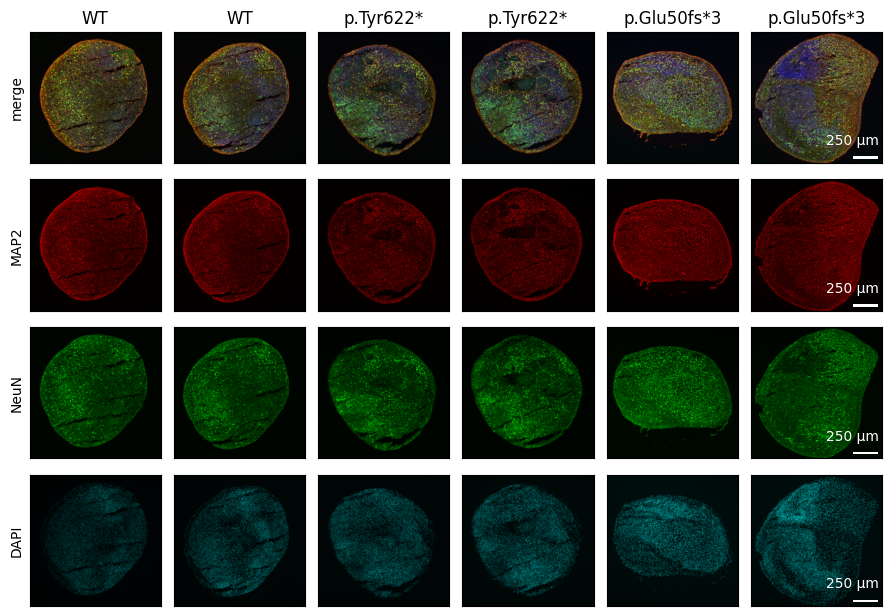

In [11]:
fig, axes = plt.subplots(4, 6, figsize=(11, 7.5))  # Create a figure with 6 rows and 2 columns
for i in (np.arange(len(images))[::-1]):
    temp = np.max(images[i], 1)
    img_channels_last = temp.transpose(1, 2, 0)
    axes[0,5-i].imshow(img_channels_last)
    axes[1,5-i].imshow(np.concatenate((img_channels_last[:,:,0:1], np.zeros_like(img_channels_last[:,:,0:1]), np.zeros_like(img_channels_last[:,:,0:1])), axis=2))
    axes[2,5-i].imshow(np.concatenate((np.zeros_like(img_channels_last[:,:,1:2]), img_channels_last[:,:,1:2], np.zeros_like(img_channels_last[:,:,1:2])), axis=2))
    axes[3,5-i].imshow(np.concatenate((np.zeros_like(img_channels_last[:,:,2:3]), img_channels_last[:,:,2:3], img_channels_last[:,:,2:3]), axis=2))

    # axes[1,i].imshow(img_channels_last[:,:,0], cmap='Reds')
    # axes[2,i].imshow(img_channels_last[:,:,1], cmap='Greens')
    # axes[3,i].imshow(img_channels_last[:,:,2], cmap='Blues')

    axes[0,5-i].set_xticks([])  
    axes[0,5-i].set_yticks([]) 
    axes[1,5-i].set_xticks([])  
    axes[1,5-i].set_yticks([])
    axes[2,5-i].set_xticks([])  
    axes[2,5-i].set_yticks([])
    axes[3,5-i].set_xticks([])  
    axes[3,5-i].set_yticks([])

    axes[0,5-i].set_title(names[i])  # Set a title for the first row
    axes[0,0].set_ylabel('merge')
    axes[1,0].set_ylabel('MAP2')
    axes[2,0].set_ylabel('NeuN')
    axes[3,0].set_ylabel('DAPI')

fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Reduce horizontal and vertical spacing between plots

# add scale bar 
import matplotlib.patches as patches

# Assume the image dimensions in out_fppc[0] (height, width)
img_height, img_width, C = img_channels_last.shape
bar_length = 200    # scale bar length in pixels (adjust as needed)
bar_height = 20     # thickness of the scale bar in pixels

# Position the scale bar in the lower right corner with some margin
margin = 30
x_start = img_width - bar_length - margin
y_start = img_height - margin

# Create a white rectangle for the scale bar
for i in range(4):
    scale_bar = patches.Rectangle((x_start, y_start - bar_height), bar_length, bar_height, 
                                linewidth=0, edgecolor=None, facecolor='white')

    axes[i, -1].add_patch(scale_bar)
    axes[i, -1].text(x_start, y_start-200, f'{bar_length *  AICSImage(os.path.join(folder_path,file_names[0])).physical_pixel_sizes[1]:.0f} μm', 
                        color='white', ha='center', va='top', fontsize=10)

plt.savefig('../../paper/extended_plots/neurospheroid_markers.png',bbox_inches='tight', dpi=500)